In [1]:
import pandas as pd
import brickschema
import psycopg2
from pathlib import Path
from dotenv import load_dotenv
import os
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# define path to env file (main directory)
dotenv_path = Path('.env')
# load env variables (credentials)
load_dotenv(dotenv_path=dotenv_path)

True

In [3]:
# loads the compiled brick schema ttl file
g = brickschema.Graph().load_file("compiled-bldg2.ttl")

In [4]:
def sparql_to_df(g, q):
    res = g.query(q) # performs the query on the model
    df = pd.DataFrame.from_records(list(res)) # transforms the results into dataframe
    df = df.applymap(str) # trasforms all to string
    df.drop_duplicates(inplace=True) # drops duplicates
    return df

def get_data(uuids, names):
    # creates connection
    dbRemote = psycopg2.connect(
        user=os.getenv('TIMESCALEDB_USER'),
        password=os.getenv('TIMESCALEDB_PSW'),
        host=os.getenv('TIMESCALEDB_HOST'),
        port=os.getenv('TIMESCALEDB_PORT'))
    
    # perform query on the timescale db
    query = "SELECT time, value, uuid FROM data WHERE uuid = ANY(%s)"
    df = pd.read_sql(query, dbRemote, params=(uuids,)) # reads from db remote
    df = df.pivot(columns='uuid', values='value', index='time') # explicit column structure
    df = df.resample('15T').mean() # syncronize the timestamp to 15 minutes
    df.columns = names

    return df
        

In [5]:
q = """
SELECT DISTINCT ?ahu ?sat ?sp ?satuuid ?spuuid WHERE {
   ?ahu  a  brick:AHU .
   ?ahu  brick:hasPoint  ?sat, ?sp .
   ?sat  a  brick:Supply_Air_Temperature_Sensor ;
         brick:timeseries [ brick:hasTimeseriesId ?satuuid ] .
   ?sp   a  brick:Supply_Air_Temperature_Setpoint ;
         brick:timeseries [ brick:hasTimeseriesId ?spuuid ]
}
"""
# for row in g.query(q):
#    print(row)

md = sparql_to_df(g, q)
md.head()

,0,1,2,3,4
0,http://buildsys.org/ontologies/BLDG2#AHU01,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,900b1843-eceb-36de-9466-cf6f901e387b,ccd88b2f-4e91-3fbc-bc73-9024ca24e99a
4,http://buildsys.org/ontologies/BLDG2#AHU02,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,c31b36e4-594b-376a-8016-be2b9d83661b,2a7ef828-52fb-38a9-927c-305aba7be9f2
8,http://buildsys.org/ontologies/BLDG2#AHU03,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,fee42dba-f1c7-3c47-95d7-9625e8f1d61f,5191665d-2f27-3b12-9372-736cc23d5b9e
12,http://buildsys.org/ontologies/BLDG2#AHU05,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,cbb6b938-a584-3dfb-9c82-0d920cf37658,a4a26d1b-ee44-3b11-b86c-4c20c3697299


In [6]:
ahu, sat, sp, satuuid, spuuid = md.values[1]
df = get_data([satuuid, spuuid], ['sat', 'sp'])
print(df.head())

/Users/roberto/Desktop/brick-data-retrieval-demo/venv/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


                            sat     sp
time                                  
2012-01-01 00:00:00+00:00  75.0  60.80
2012-01-01 00:15:00+00:00  75.0  60.75
2012-01-01 00:30:00+00:00  75.0  60.55
2012-01-01 00:45:00+00:00  75.0  60.70
2012-01-01 01:00:00+00:00  75.0  60.85


/var/folders/pw/d40r29kd14dctjy4skv66h0r0000gn/T/ipykernel_6626/3517490089.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

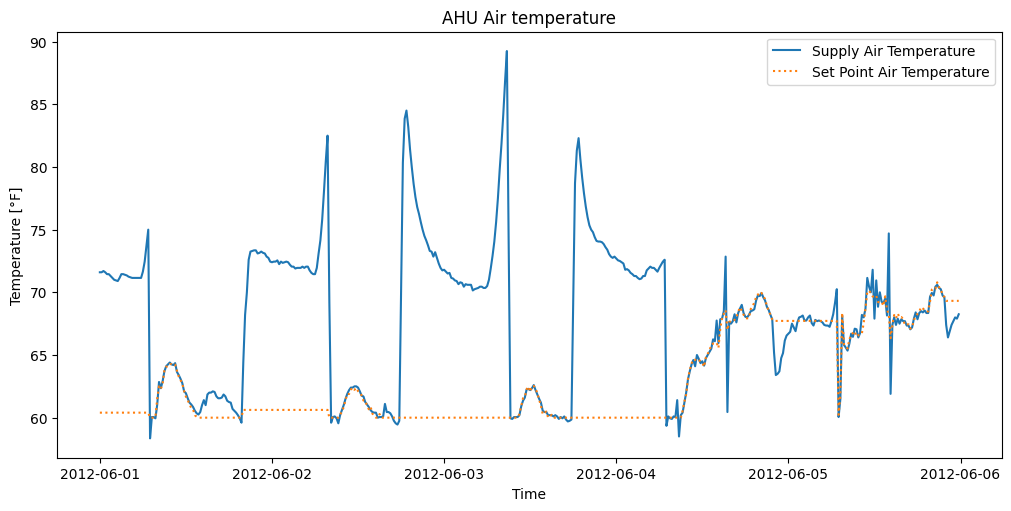

In [7]:

fig = plt.figure()  # an empty figure with no Axes
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')  # a figure with a single Axes
ax.plot(df['2012-06-01':'2012-06-5']['sp'], linestyle='-', label='Supply Air Temperature') 
ax.plot(df['2012-06-01':'2012-06-5']['sat'], linestyle=':', label='Set Point Air Temperature')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°F]');
ax.set_title("AHU Air temperature")  # Add a title to the axes.
ax.legend();  # Add a legend.
fig.show()